# Import Libraries

In [1]:
import numpy as np
# Import the standard libraries from Qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
# Import Simulators
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer import AerSimulator
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# The Different Quantum Query Representation Algorithms

### 1. Query Representation with Standard and Reset Gate

As ancilla qubits can be reused due to the **Reset Gate**, the algorithm only requires **4** ancilla qubits.

The equality operator requires only **2** ancilla qubits.

In [14]:
def db_operator_4anc(qc, op, val, m):
#     If there are no qubits in the data there is no need to run the algorithm
    if m == 0:
        return
    
#     Set (m+1)th qubit to '1'
    qc.x(m)
    
#     Find the binary representation of val
    val_bin = []
    for i in range(m):
        val_bin.append(val%2)
        val //= 2

#     If the val has more bits than m, then it is always greater than the value in qc
    if val != 0:
        if op in [">", ">=", "=="]:
            qc.x(m)
        for i in range(m+1):
            qc.measure(i,i)
        return
    
#     If the current bit in val is 0, check if the corresponding bit in qc is 1. If so, the curr_0 qubit is reset to 0.
#     If the current bit in val is 1, check if curr_0 is 1 and the corresponding bit in qc is 0. If so, the curr_1 qubit is set to 1.
    curr_0, curr_1 = m, m+1
    for i in range(m-1, -1, -1):
        k = 3*m + 3 - curr_1 - curr_0
        if val_bin[i] == 1:
            qc.x(i)
            qc.ccx(i, curr_0, m+3)
            qc.x(i)
            
            qc.reset(k)
            qc.cx(curr_1, k)
            qc.x(curr_1)
            qc.ccx(curr_1, m+3, k)
            curr_1 = k
            qc.barrier()
        else:
            qc.reset(k)
            qc.cx(curr_0, k)
            qc.ccx(i, curr_0, k)
            curr_0 = k
            qc.barrier()
    
#     If curr_0 = 1 and curr_1 = 1, then the value in qc is less than val
#     If curr_0 = 1 and curr_1 = 0, then the value in qc is equal than val
#     If curr_0 = 0 and curr_1 = 1, then the value in qc is less than val
#     If curr_0 = 0 and curr_1 = 0, then the value in qc is greater than val
#     Use the above logic to identify the correctness of (value in qc) op val and measure it
    if op in ["==", "!=", ">", "<="]:
        if op in [">", "<="]:
            qc.x(curr_0)
        qc.x(curr_1)
        qc.reset(m+3)
        qc.ccx(curr_0, curr_1, m+3)
        if op in ["!=", "<="]:
            qc.x(m+3)
        qc.measure(m+3, m)
    else:
        if op == ">=":
            qc.x(curr_1)
        qc.measure(curr_1, m)
    
    for i in range(m):
        qc.measure(i,i)

### 2. Query Representation with Indicator Ancilla Qubits

With the use of the **Additional Ancilla Qubits and Swap Gate**, the number of ancilla qubits can be brought down to **3**.

In [7]:
def eq_operator_2anc(qc, op, val, m):
    
    """
        Ancilla Qubits: 2
        Operations done: <= 5m
        
        Barriers are optional and is not required for the correctness of the circuit.
        It is used just to make the circuit diagram easier to understand
    """
    
#     If there are no qubits in the data there is no need to run the algorithm    
    if m == 0:
        return

#     Find the binary representation of val
    val_bin = []
    for i in range(m):
        val_bin.append(val % 2)
        val //= 2
    
    print(val_bin)
    
    if val != 0:
        qc.measure(m, 0)
        return
    
    qc.x(m+1)
    

    for i in range(m-1,-1,-1):
        if val_bin[i] == 0:
            qc.reset(m)
            qc.ccx(i,m+1,m)
            qc.cx(m,m+1)
            qc.barrier()
        else:
            qc.reset(m)
            qc.x(i)
            qc.ccx(i,m+1,m)
            qc.cx(m,m+1)
            qc.x(i)
            qc.barrier()
            
    if op == "!=":
        qc.x(m+1)
        
    # Measuring all the data qubits for VERIFICATION of output
    # Optional, can be removed
    for i in range(m):
        qc.measure(i,i)
        
    # Measuring the output qubit
    qc.measure(m+1, m)

In [19]:
def db_operator_3anc(qc, op, val, m):
    
    """
        Ancilla Qubits: 3
        Operations done: <= 6m
        
        Barriers are optional and is not required for the correctness of the circuit.
        It is used just to make the circuit diagram easier to understand
    """
    
#     If there are no qubits in the data there is no need to run the algorithm    
    if m == 0:
        return

#     Find the binary representation of val
    val_bin = []
    for i in range(m):
        val_bin.append(val % 2)
        val //= 2
    
    print(val_bin)
    
    if val != 0:
        qc.measure(m, 0)
        return
    
    qc.x(m+2)
    
    for i in range(m-1,-1,-1):
        if val_bin[i] == 0:
            if i == m-1:
                qc.x(m)
                qc.cx(i, m)
                qc.cx(i, m+2) 
                qc.barrier()
            elif i == 0 and (op == "<" or op == ">="):
                qc.cx(m,m+2)
                qc.barrier()
            else:
                qc.ccx(i,m,m+2)
                qc.reset(m+1)
                qc.x(i)
                qc.ccx(i,m,m+1)
                qc.swap(m,m+1)
                qc.x(i)
                qc.barrier()
        else:
            if i == m-1:
                qc.cx(i,m)
                qc.barrier()
            elif i == 0 and (op == "<" or op == ">="):
                qc.ccx(m,i,m+2)
                qc.barrier()
            else:
                qc.reset(m+1)
                qc.ccx(i,m,m+1)
                qc.swap(m,m+1)
                qc.barrier()
            
    if op == ">=" or op == ">":
        qc.x(m+2)
    
    # Measuring all the data qubits for VERIFICATION of output
    # Optional, can be removed
    for i in range(m):
        qc.measure(i,i)
    
    # Measuring the output qubit
    qc.measure(m+2, m)

### 3. Query Representation with Control on Classical bit

If **measurements** on the Ancilla qubits are allowed, then the number of ancilla qubits can be reduced to **2**.

The number of ancilla qubits on just the equality operator can be reduced to just **1**.

In [20]:
def eq_operator_1anc(qc, op, val, m):
    
    """
        Ancilla Qubits: 1
        Operations done: <= 4m
        
        Barriers are optional and is not required for the correctness of the circuit.
        It is used just to make the circuit diagram easier to understand
    """
    
#     If there are no qubits in the data there is no need to run the algorithm    
    if m == 0:
        return
    
#    Find the binary representation of val    
    val_bin = []
    for i in range(m):
        val_bin.append(val % 2)
        val //= 2
    
    print(val_bin)
    
    if val != 0:
        qc.measure(m, 0)
        return
    
    qc.x(m)
    
    for i in range(m-1,-1,-1):
        if val_bin[i] == 0:
            qc.measure(m, 0)
            qc.cx(i,m).c_if(0, 1)
            qc.barrier()
        else:
            qc.x(i)
            qc.measure(m, 0)
            qc.cx(i,m).c_if(0, 1)
            qc.x(i)
            qc.barrier()
    if op == "!=":
        qc.x(m)
        
    # Measuring Data qubits for Verfiication
    # Remove in actual run
    for i in range(m):
        qc.measure(i,i)
    
    # Measuring Output qubit
    qc.measure(m, m)

In [21]:
def db_operator_2anc(qc, op, val, m):
    
    """
        Ancilla Qubits: 2
        Operations done: <= 4m
        
        Barriers are optional and is not required for the correctness of the circuit.
        It is used just to make the circuit diagram easier to understand
    """
    
#     If there are no qubits in the data there is no need to run the algorithm    
    if m == 0:
        return

#     Find the binary representation of val
    val_bin = []
    for i in range(m):
        val_bin.append(val % 2)
        val //= 2
    
    print(val_bin)
    
    if val != 0:
        qc.measure(m, 0)
        return
    
    qc.x(m+1)
    
    for i in range(m-1,-1,-1):
        if val_bin[i] == 0:
            if i == m-1:
                qc.x(m)
                qc.cx(i, m)
                qc.cx(i, m+1) 
                qc.barrier()
            elif i == 0 and (op == "<" or op == ">="):
                qc.cx(m,m+1)
                qc.barrier()
            else:
                qc.ccx(i,m,m+1)
                qc.measure(m, 0)
                qc.cx(i,m).c_if(0, 1)
                qc.barrier()
        else:
            if i == m-1:
                qc.cx(i,m)
                qc.barrier()
            elif i == 0 and (op == "<" or op == ">="):
                qc.ccx(m,i,m+1)
                qc.barrier()
            else:
                qc.x(i)
                qc.measure(m, 0)
                qc.cx(i,m).c_if(0, 1)
                qc.x(i)
                qc.barrier()
    if op == ">=" or op == ">":
        qc.x(m+1)
    
    # Measuring Data qubits for Verfiication
    # Remove in actual run
    for i in range(m):
        qc.measure(i,i)
        
    # Measuring Output qubit
    qc.measure(m+1, m)

In [22]:
#  The Operator with the smallest number of ancilla Qubits
def db_operator(qc, op, val, m):
    if op == '==' or op == '!=':
        eq_operator_1anc(qc, op, val, m)   # Using our final algorithm
    else:
        db_operator_2anc(qc, op, val, m)   # Using our final algorithm

# Experiments

The following experiments are only for the case with measurements on the ancilla qubits as it is the operator that uses the least number of ancilla qubits.

Create a Quantum Circuit with the necessary ancilla and initialize the values

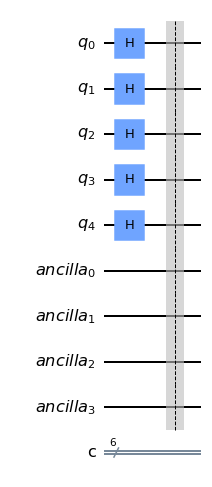

In [23]:
# Input Parameters
op = '<='
val = 14
m = 5

# Create the Quantum Circuit

q = QuantumRegister(m, 'q')

# Using m+1 classical bits for verification of data qubits
# Just 1 classical bit is required for actual working
cr = ClassicalRegister(m+1, 'c')


if op == '==' or op == '!=':
    ac = QuantumRegister(1, 'ancilla')
else:
    ac = QuantumRegister(2, 'ancilla')
    
qc = QuantumCircuit(q, ac, cr)


#     Initialize the value encoded in the Quantum Circuit
for i in range(m):
    qc.h(i)
qc.barrier()

#     Visual Representation of the Circuit
qc.draw()

Run the *db_operator* and draw the visual representation of the Circuit

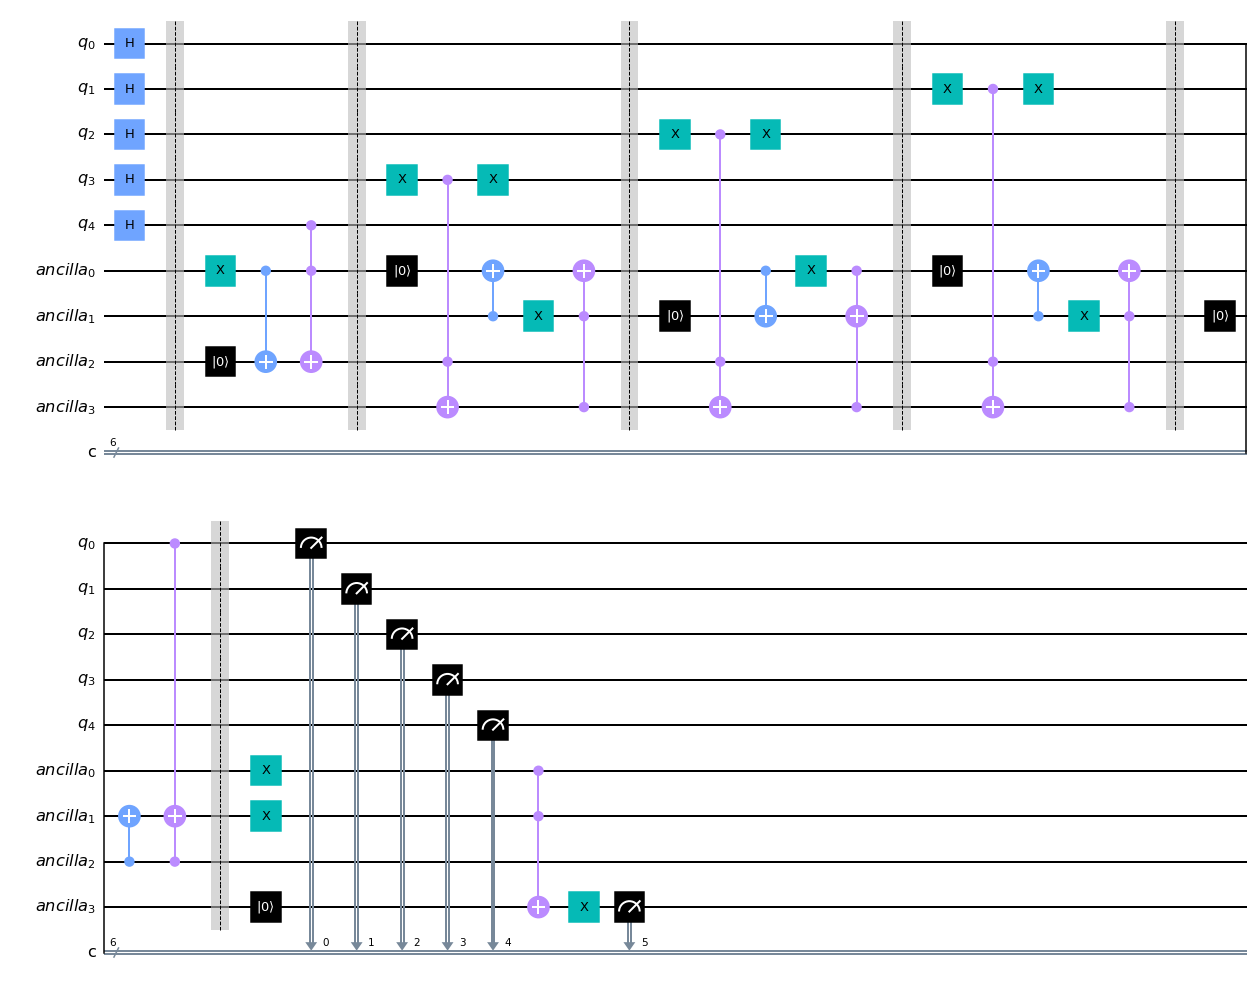

In [24]:
db_operator(qc, op, val, m)
qc.draw()

Create a Simulator to run the Circuit

In [25]:
sim = AerSimulator()

Run the simulator and the get the Results

In [26]:
job = sim.run(qc)      # run the experiment
result = job.result()  # get the results

To test the results, check if the given output matches the values measured from qc

{'101010': 39, '100001': 36, '101011': 31, '100100': 35, '011001': 24, '101101': 35, '011100': 21, '011110': 38, '011101': 31, '100000': 21, '010100': 36, '100011': 36, '011011': 37, '100010': 25, '011111': 27, '010110': 39, '010010': 30, '100110': 26, '011010': 40, '001111': 34, '101110': 25, '010011': 22, '010000': 23, '010101': 38, '010001': 27, '101100': 45, '011000': 27, '010111': 29, '101001': 34, '101000': 37, '100101': 44, '100111': 32}


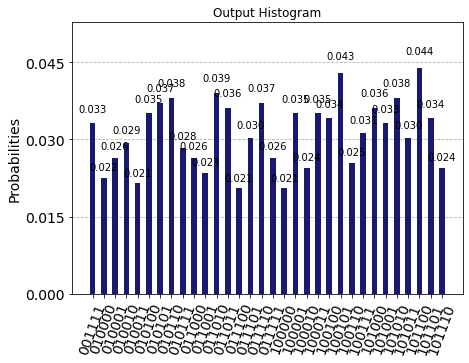

In [27]:
print(result.get_counts())
plot_histogram(result.get_counts(), color='midnightblue', title="Output Histogram")

In [28]:
a,b =[],[]
for i in result.get_counts():
    if i[0] == '0':
        a.append(int(i[1:],2))
    else:
        b.append(int(i[1:],2))

a.sort()
print("Numbers with output 0:", a)

b.sort()
print("Numbers with output 1:", b)

Numbers with output 0: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Numbers with output 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
